In [2]:
%matplotlib inline
from bs4 import BeautifulSoup
import urllib2
import urllib
import json
import csv
import time
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [6]:
funding_df=pd.read_csv("funding.csv")
funding_df.fillna('', inplace=True)
funding_df = funding_df.replace(['Unknown'], [''])
funding_df.head()

,Description,Market,Names,No_Stage_Amount,No_Stage_Date,Pitch,Seed_Amount,Seed_Date,Series_A_Amount,Series_A_Date,Series_B_Amount,Series_B_Date,Series_C_Amount,Series_C_Date,Series_D_Amount,Series_D_Date,Stage
0,,Cable,Epic-Sciences,,,,,,,,"$13,000,000","Nov 13, 2012","$30,000,000","Jul 30, 2014",,,Series C
1,,All Students,Apreso-Classroom,,,,,,,,"$15,000,000","Oct 14, 2008",,,,,Series B
2,Visualead (视觉码) creates better interactions be...,Bridging Online and Offline,Visualead,,,Effective and Secure Offline to Mobile experie...,"$750,000","Mar 25, 2012","$1,600,000","Aug 15, 2013",,"Jan 20, 2015",,,,,Series B
3,,Food Processing,Onshift,"$7,000,000","Feb 3, 2014",,,,,,"$3,000,000","Feb 2, 2012",,,,,Series C
4,,-,Xendex-Holding,,,,,,,"Jun 25, 2008","$3,500,000","Nov 30, 2009",,,,,Series A


In [33]:
def find_stats(funding):
    amounts = filter(lambda x: x!='', list(funding))
    amounts = map(lambda x: int(x[1:].replace(',', '')), amounts)
    return np.mean(amounts), np.std(amounts), max(amounts), min(amounts)
    
(find_stats(funding_df.Series_A_Amount), find_stats(funding_df.Series_B_Amount), find_stats(funding_df.Series_C_Amount), find_stats(funding_df.Series_D_Amount))

((5974206.0607361961, 5542666.9309859239, 76000000, 56300),
 (11512685.208875287, 9372374.3103021737, 85000000, 88900),
 (16317432.270710059, 12946385.665555209, 99000000, 45),
 (16693317.080402009, 12485770.709775113, 75000000, 100000))

It looks like the average Series A funding round is approximately \$6 million, the average Series B funding round is \$11 million, the average Series C funding round is \$16 million, and the average Series D funding round is around \$17 million dollars. It is extremely clear though that there is a lot of variance in the amount of money raised for each company though. Let's perform some exploratory analysis by looking at some plots. 

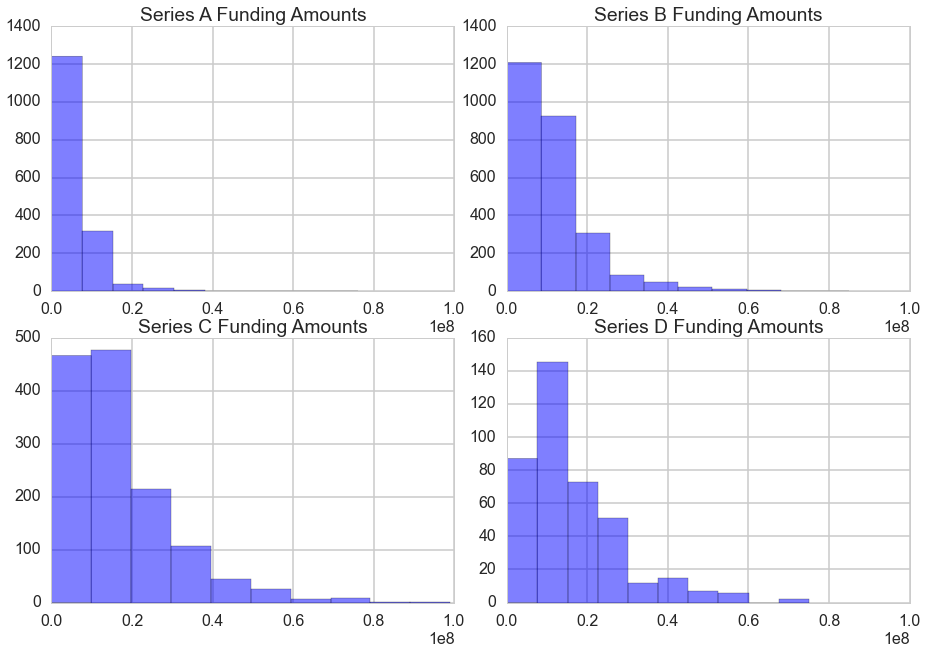

In [58]:
def create_plot(funding_df):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout()
    round_title = ['Series A Funding Amounts', 'Series B Funding Amounts', 'Series C Funding Amounts', 'Series D Funding Amounts']
    rounds = [funding_df.Series_A_Amount, funding_df.Series_B_Amount, funding_df.Series_C_Amount, funding_df.Series_D_Amount]
    for ax, i in zip(axes.ravel(), range(len(rounds))):
        funding = rounds[i] 
        amounts = filter(lambda x: x!='', list(funding))
        amounts = map(lambda x: int(x[1:].replace(',', '')), amounts)
        ax.hist(amounts, color='b', alpha=0.5)
        ax.set_title(round_title[i])
        ax.set_xlim(0, 1e8)

create_plot(funding_df)
    

In [25]:
def create_plot_log(funding_df):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout()
    round_title = ['Series A Funding Amounts', 'Series B Funding Amounts', 'Series C Funding Amounts', 'Series D Funding Amounts']
    rounds = [funding_df.Series_A_Amount, funding_df.Series_B_Amount, funding_df.Series_C_Amount, funding_df.Series_D_Amount]
    for ax, i in zip(axes.ravel(), range(len(rounds))):
        funding = rounds[i] 
        amounts = filter(lambda x: x!='', list(funding))
        amounts = map(lambda x: int(x[1:].replace(',', '')), amounts)
        ax.hist(np.log(amounts), color='b', alpha=0.5)
        ax.set_title(round_title[i])
        

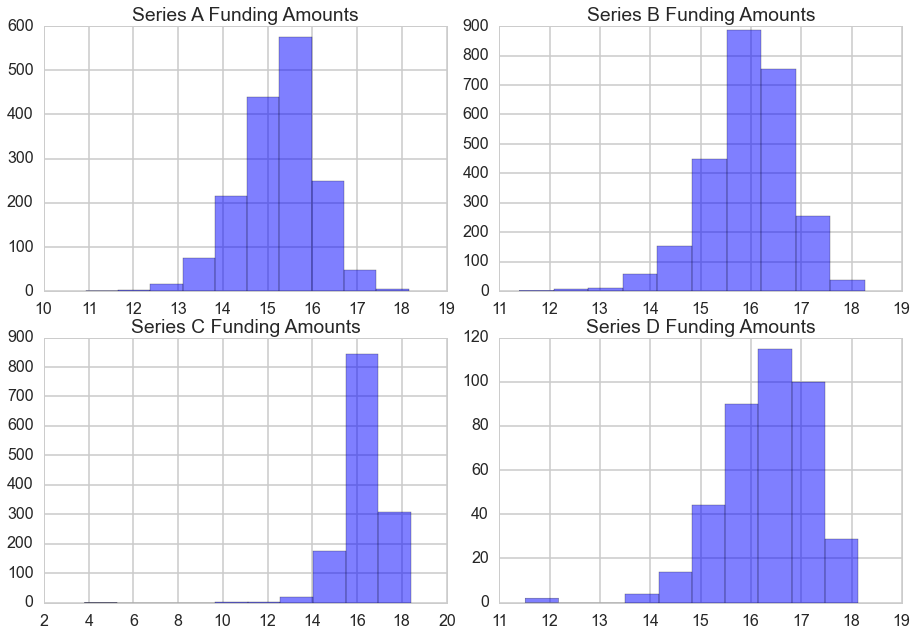

In [26]:
create_plot_log(funding_df)

It seems that the funding amounts are positively skewed. The funding amounts also do not follow a normal distribution. A log transformation appears to help achieve normality.

### Naive Methods of Prediction

Without Twitter data, let's perform the most naive way of predicting funding round amounts by predicting the average Series amount. We'll see what the root mean squared error for this method is, and use this as a baseline. 

In [101]:
series_A = funding_df[funding_df['Series_A_Amount'] != ''][['Names', 'Series_A_Amount', 'Market']]
series_A.columns = ['Names', 'Series_Amount', 'Market']
series_A['Series_Type'] = pd.Series('Series_A', index=series_A.index)

series_B = funding_df[funding_df['Series_B_Amount'] != ''][['Names', 'Series_B_Amount', 'Market']]
series_B.columns = ['Names', 'Series_Amount', 'Market']
series_B['Series_Type'] = pd.Series('Series_B', index=series_B.index)

series_C = funding_df[funding_df['Series_C_Amount'] != ''][['Names', 'Series_C_Amount', 'Market']]
series_C.columns = ['Names', 'Series_Amount', 'Market']
series_C['Series_Type'] = pd.Series('Series_C', index=series_C.index)

series_D = funding_df[funding_df['Series_D_Amount'] != ''][['Names', 'Series_D_Amount', 'Market']]
series_D.columns = ['Names', 'Series_Amount', 'Market']
series_D['Series_Type'] = pd.Series('Series_D', index=series_D.index)

funding_collapsed = pd.concat([series_A, series_B, series_C, series_D])
funding_collapsed.head()

,Names,Series_Amount,Market,Series_Type
2,Visualead,"$1,600,000",Bridging Online and Offline,Series_A
5,filmloop,"$5,600,000",Software,Series_A
6,Mochi-Media,"$4,000,000",,Series_A
7,SkyRecon-Systems,"$3,730,000",-,Series_A
8,Lumos-Labs,"$3,100,000",,Series_A


As usual, we also create a test and train set. We will calculate the averages based off of the train set to make sure that no leakage occurs into the test set of our data. Below, we also write a root mean squared error to determine our average error. 

In [118]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(funding_collapsed.shape[0]), train_size=0.7)
mask=np.ones(funding_collapsed.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask=(mask==1)
funding_train = funding_collapsed[mask]
funding_test = funding_collapsed[~mask]
funding_train.head()

,Names,Series_Amount,Market,Series_Type
2,Visualead,"$1,600,000",Bridging Online and Offline,Series_A
5,filmloop,"$5,600,000",Software,Series_A
6,Mochi-Media,"$4,000,000",,Series_A
9,ROBLOX,"$2,200,000",Blockchains,Series_A
10,SendHub,"$3,000,000",B2B,Series_A


In [216]:
series_a_avg = find_stats(funding_train[funding_train['Series_Type'] == 'Series_A'].Series_Amount)[0]
series_b_avg = find_stats(funding_train[funding_train['Series_Type'] == 'Series_B'].Series_Amount)[0]
series_c_avg = find_stats(funding_train[funding_train['Series_Type'] == 'Series_C'].Series_Amount)[0]
series_d_avg = find_stats(funding_train[funding_train['Series_Type'] == 'Series_D'].Series_Amount)[0]

def return_series_avg(stage):
    if stage == 'Series_A':
        return series_a_avg
    elif stage == 'Series_B':
        return series_b_avg
    elif stage == 'Series_C':
        return series_c_avg 
    elif stage == 'Series_D':
        return series_d_avg
    else:
        return 1

def rmse(testdf):
    return np.sqrt(np.mean(map(lambda pred, actual: (pred-int(actual[1:].replace(',', '')))**2, testdf['Predicted_Amount'], testdf['Series_Amount'])))
    
rmse(funding_test)

10495839.87337919

The root mean squared error is approximately \$10 million. This will be the baseline for the rest of our approaches through the rest of this project.